# 5TF078 Deep Learning Course
## Laboration 3 om Tidsserier/RNN
Created by Tomas Nordström, Umeå University

This is a brief introduction to tensors as used in Tensorflow/Keras

Revisions:
*  2023-04-20 Initial version /ToNo
*  2023-05-01 Fixed a off-by-one bug in datasetgen, calculating offset. Also added timing of the model training. /ToNo
*  2023-09-14 Implemented a new datasetgen, that can handle targets with more than one time step (label_width>1) /ToNo
*  2023-10-22 Update keras imports to prepare for Keras 3.0 /ToNo
*  2023-11-30 Added calculation of target dataset size, and some minor text updates /ToNo
*  2023-12-02 Fixed a bug in datasetgen where last dataset might be too short. /ToNo
*  2024-04-22 Re-added lost "import sys". /Tomas

#Cristina Zhang
#zhangjinting118@gmail.com

# Introduktion

Laborationens mål är att använda ett återkopplat neuronnät (eng. Recurrent Neural Network, RNN) modell (t.ex. LSTM) för att göra prediktioner av en tidsserie av väderdata.

# Python Setup

In [ ]:
# Import needed libraries
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

import keras
print('Keras version:', keras.__version__)

# from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D
from keras.utils  import to_categorical

# print('Keras version:',keras.__version__)

# Matlab plotting
import matplotlib
import matplotlib.pyplot as plt
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

# Helper libraries
import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import sklearn
from   sklearn.model_selection import train_test_split

import IPython
import IPython.display
import seaborn as sns

TensorFlow version: 2.17.1
Keras version: 3.5.0


In [ ]:
# Test for GPU and determine what GPU we have
gpu_devices = tf.config.list_physical_devices('GPU')

if not gpu_devices:
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")
else:
  !nvidia-smi -L

# If possible to run code wiht 16 bits float instad of 32 bits float, this code acitvates such functionality:
if gpu_devices:
 details = tf.config.experimental.get_device_details(gpu_devices[0])
 compute_capability=details.get('compute_capability')
 print("Compute capability:",compute_capability)
 if compute_capability[0]>6:
   print("Turning on mixed_float16")
   policy = keras.mixed_precision.Policy('mixed_float16')
   keras.mixed_precision.set_global_policy(policy)

No GPU was detected. Neural nets can be very slow without a GPU.
Go to Runtime > Change runtime and select a GPU hardware accelerator.


# Del 1:  Första delen av uppgiften har följande underdelar
* Förstå dataförbehanlingen som görs nedan, dels att förbereda tidssekvensen med dess olika parametrar, dels förstå hur han skapar sekvenser/fönster som kan användas för att träna våra RNN-modeller.
* Reflekterar över vilken förlustfunktion som kan vara bäst för detta problem
* Skapa en baseline att jämföra med
* Träna en enkel LSTM modell för att prediktera en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input.

## Som data används väderdata

Denna laboration använder en <a href="https://www.bgc-jena.mpg.de/wetter/" class="external">vädertidsserie</a> uppmätt vid av Max Planck Institute for Biogeochemistry.

Denna datauppsättning innehåller 14 olika parametrar som lufttemperatur, atmosfärstryck och luftfuktighet. Dessa samlades in var tionde minut, med början 2003. För att vara lite effektiva kommer du endast att använda data som samlats in mellan 2009 och 2016. Den här delen av datamängden förbereddes av François Chollet för sin bok [Deep Learning with Python](https:// www.manning.com/books/deep-learning-with-python).


## Climate Data Time-Series
**Location**: Weather Station, Max Planck Institute for Biogeochemistry
in Jena, Germany

**Time-frame Considered**: Jan 10, 2009 - December 31, 2016

The table below shows the column names, their value formats, and their description.

Index| Features      |Format             |Description
-----|---------------|-------------------|-----------------------
1    |Date Time      |01.01.2009 00:10:00|Date-time reference
2    |p (mbar)       |996.52             |The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
3    |T (degC)       |-8.02              |Temperature in Celsius
4    |Tpot (K)       |265.4              |Temperature in Kelvin
5    |Tdew (degC)    |-8.9               |Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
6    |rh (%)         |93.3               |Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
7    |VPmax (mbar)   |3.33               |Saturation vapor pressure
8    |VPact (mbar)   |3.11               |Vapor pressure
9    |VPdef (mbar)   |0.22               |Vapor pressure deficit
10   |sh (g/kg)      |1.94               |Specific humidity
11   |H2OC (mmol/mol)|3.12               |Water vapor concentration
12   |rho (g/m ** 3) |1307.75            |Airtight
13   |wv (m/s)       |1.03               |Wind speed
14   |max. wv (m/s)  |1.75               |Maximum wind speed
15   |wd (deg)       |152.3              |Wind direction in degrees

In [ ]:
zip_path = keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
df = pd.read_csv(csv_path)

In [ ]:
# This lab will just deal with hourly predictions, so start by sub-sampling the data from 10 minute intervals to 1h:
df = df[5::6] # starting from index 5 take every 6th record.

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [ ]:
print(df.shape)
# Let's take a glance at the data. Here are the first few rows:
df.head()

(70091, 14)


,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


Here is the evolution of a few features over time.

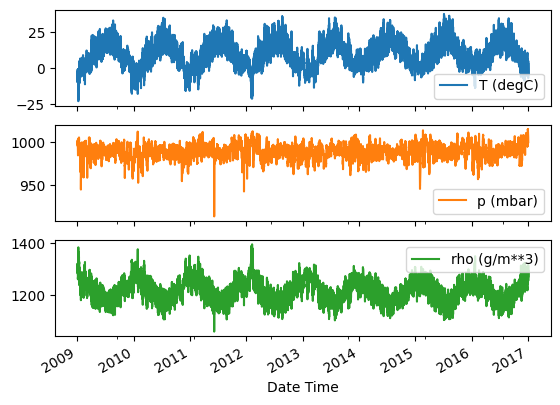

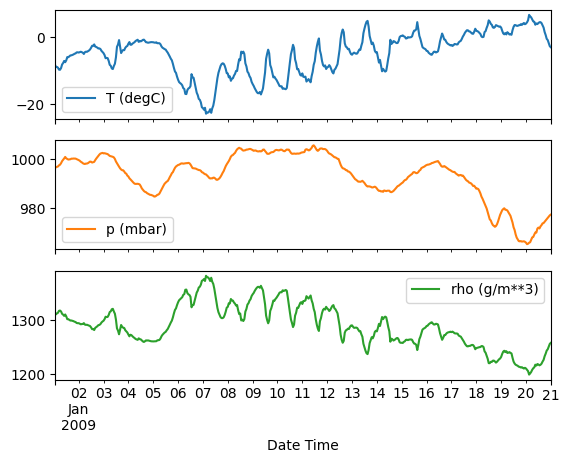

In [ ]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

### Inspect and cleanup

Next look at the statistics of the dataset:

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


#### Wind velocity

One thing that should stand out is the `min` value of the wind velocity, `wv (m/s)` and `max. wv (m/s)` columns. This `-9999` is likely erroneous. There's a separate wind direction column, so the velocity should be `>=0`. Replace it with zeros:


In [ ]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

### Feature engineering

Before diving in to build a model it's important to understand your data, and be sure that you're passing the model appropriately formatted data.

#### Wind
The last column of the data, `wd (deg)`, gives the wind direction in units of degrees. Angles do not make good model inputs, 360° and 0° should be close to each other, and wrap around smoothly. Direction shouldn't matter if the wind is not blowing.

Right now the distribution of wind data looks like this:

Text(0, 0.5, 'Wind Velocity [m/s]')

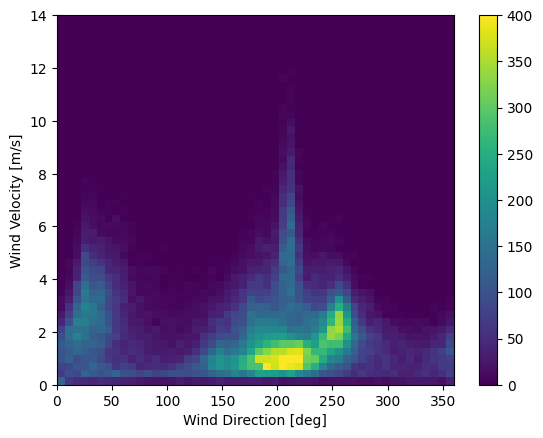

In [ ]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

But this will be easier for the model to interpret if you convert the wind direction and velocity columns to a wind **vector**:

In [ ]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

The distribution of wind vectors is much simpler for the model to correctly interpret.

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

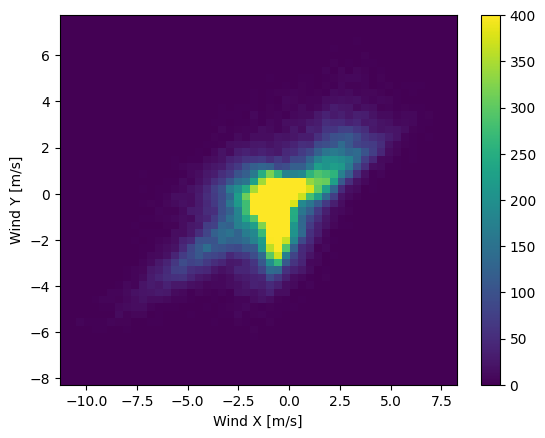

In [ ]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

#### Time

Similarly the `Date Time` column is very useful, but not in this string form. Start by converting it to seconds:

In [ ]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use `sin` and `cos` to convert the time to clear "Time of day" and "Time of year" signals:

In [ ]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

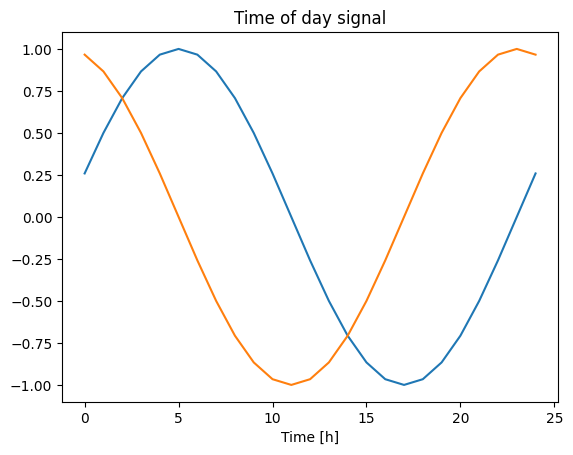

In [ ]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case you knew ahead of time which frequencies were important.

If you didn't know, you can determine which frequencies are important using an `fft`. To check our assumptions, here is the `tf.signal.rfft` of the temperature over time. Note the obvious peaks at frequencies near `1/year` and `1/day`:

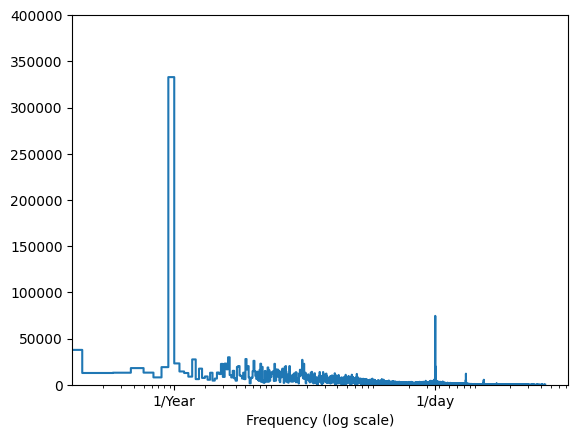

In [ ]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

## Uppgift Besvara följande frågor
Denna kod gör ganska omfattande förbehandling av väderdatat innan man kan använda det för träning, se till att du förstår vad som sker (men du behöver inte förändra något) och beskriv följade:
* Det finns en eller flera variabler med extrema (fysiskt omöjliga) värden, vilka är det, och vad görs för att hantera dem?
* Varför har maskininlärningsmodeller svårt att hantera en vindriktning som anges i grader, vad föreslås som alternativ att representera vindriktning istället?
* Även tid, mätt i sekunder/timmar etc. gör det onödigt svårt för modeller att hitta mönster i vissa typer av tidsserier, vad för slags variabler föreslås i koden att man lägger till för väderdata? Om detta istället hade varit energiförbrukningsdata, vilken periodisitet borde man då utökat med?


1. **Variables with Extreme Values** : Wind velocity (`wv (m/s)`) and max wind velocity (`max. wv (m/s)`) contain impossible values, like negatives, which are replaced with valid ones.  

2. **Why Models Struggle with Wind Direction in Degrees** : Degrees (0–360°) create a discontinuity, making it hard for models to interpret. Using x and y vector components (`Wx`, `Wy`) avoids this issue.  

3. **Handling Time in Weather Data**  : Time is represented as sine and cosine values (`Day sin`, `Day cos`) to capture periodic patterns like day/night cycles.  

4. **Periodicity for Energy Consumption** : Add daily, weekly, and seasonal sine/cosine transformations to reflect energy usage patterns.  


##Datauppdelning och fönster

Förutom att dela upp denna tidsserie i våra tre olika datamängder behöver vi konvertera tidsserien till kortare sekvenser/fönster och lämpliga utvärden (motsvarande de "labels" vi använde i Lab 1&2).

Detta med fönster kan vara lite svårt att få ordning på så jag har skapat en lite introduktion här: https://colab.research.google.com/drive/1GU3WWJ4c3KWa8xrj5bZdnJp5PaIDjWYr?usp=sharing

## Back to our real data, start by finding splitting points

In [ ]:
# Find index to where we want to split our data into our datasets
DataSplitRatios=(0.7,0.2,0.1) # Maybe one should check this sums up to 1?
n = len(df)
split1ix = int(n*DataSplitRatios[0])
split2ix = int(n*(DataSplitRatios[0]+DataSplitRatios[1]))
print(split1ix,split2ix,n)

49063 63081 70091


### Normalize the data

It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.
Note that the mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

The data is normalized so that the data is in the same distribution which makes the models to be able to learn easier.

In [ ]:
train_mean = df[0:split1ix].mean()
train_std = df[0:split1ix].std()
dfnorm = (df - train_mean) / train_std

Now peek at the distribution of the features. Some features do have long tails, but there are no obvious errors like the `-9999` wind velocity value.

<ipython-input-84-b0c5385fac08>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


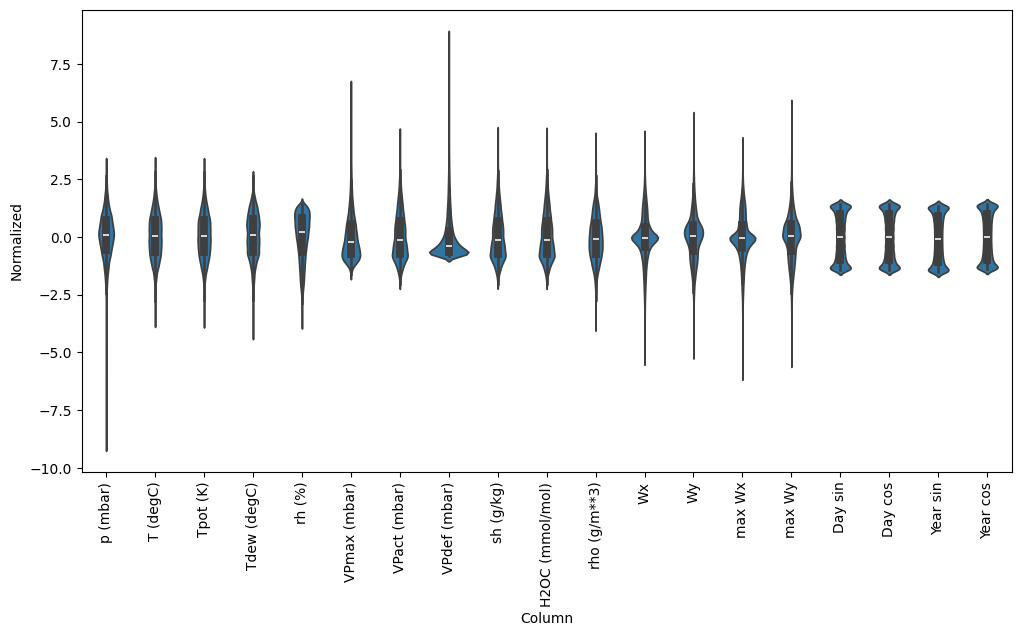

In [ ]:
df_std = dfnorm.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Uppgift Del 1
Vi ska prediktera en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input.

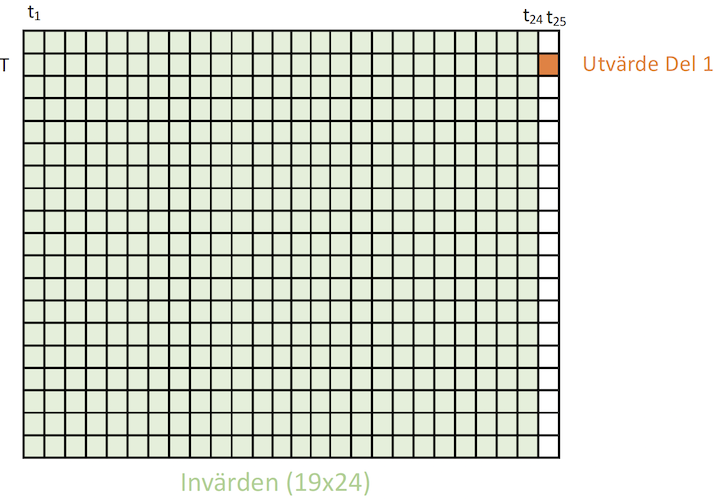

## Förbered våra tre "dataset"

In [ ]:
# Help function to get indices for columns based on column names
def get_label_columns_indices(dataframe,label_columns=None):
  if label_columns is None:
    # Take all columns if label_columns is None
    label_columns_indices = {name: i for i, name in enumerate(dataframe.columns)}
  else:
    # Else take the columns indicated
    label_columns_indices = {name: i for i, name in enumerate(label_columns)}
  return label_columns_indices

In [ ]:
# Test get_label_columns_indices
lcol= None
lci = get_label_columns_indices(dfnorm,lcol)
print(lci)
lcol= lcol= ['T (degC)']
lci = get_label_columns_indices(dfnorm,lcol)
print(lci)

{'p (mbar)': 0, 'T (degC)': 1, 'Tpot (K)': 2, 'Tdew (degC)': 3, 'rh (%)': 4, 'VPmax (mbar)': 5, 'VPact (mbar)': 6, 'VPdef (mbar)': 7, 'sh (g/kg)': 8, 'H2OC (mmol/mol)': 9, 'rho (g/m**3)': 10, 'Wx': 11, 'Wy': 12, 'max Wx': 13, 'max Wy': 14, 'Day sin': 15, 'Day cos': 16, 'Year sin': 17, 'Year cos': 18}
{'T (degC)': 0}


In [ ]:
# Define a windowing function that converts a dataframe into a TF dataset
# Had to jump to some hoops for this as keras.utils.timeseries_dataset_from_array do not support label_width>1
# https://github.com/keras-team/tf-keras/issues/7
def datasetgen(dataframe, input_width=24, label_width=1, shift=1, batch_size=128,
  label_columns=None, start_index=None, end_index=None, shuffle=False):
  """
  Generate timeseries dataset from the given dataframe containing a data sequence.

  Parameters:
  - dataframe: The source time sequence dataframe.
  - input_width: Number of time steps in each input sequence.
  - label_width: Number of time steps in each label sequence.
  - shift: How many steps to shift the end of the input to get the label.
  - batch_size: Size of batches to generate.
  - label_columns: List of column names to extract as labels. If None, all columns are used.
  - start_index: Start index from the dataframe to consider data. Default is the start of the dataframe.
  - end_index: End index from the dataframe to consider data. Default is the end of the dataframe.
  - shuffle: Whether to shuffle the generated batches. Note: shuffling won't work in the current implementation.

  Returns:
  - A TensorFlow Dataset containing input and label sequences.
  """

  # If end index or start index is not given, assign them to the end or start of the dataframe respectively.
  if end_index is None:
      end_index = len(dataframe) + input_width - 2
  if start_index is None:
      start_index = 0

  # Generate a input timeseries dataset from the dataframe using keras.utils.timeseries_dataset_from_array
  input_ds = keras.utils.timeseries_dataset_from_array(
                  dataframe, targets=None, sequence_length=input_width,
                  sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
                  start_index=start_index, end_index=(end_index-(input_width+shift-1)))

  # Fetch the indices of the label columns from the dataframe.
  label_columns_indices = get_label_columns_indices(dataframe,label_columns) # get the selected columns
  targetsdf = dataframe[list(label_columns_indices)]

  # Generate a timeseries dataset of label sequences from the dataframe.
  # Here we assume that label_width should be less than or equal to shift.
  target_ds = keras.utils.timeseries_dataset_from_array(
                  targetsdf, targets=None, sequence_length=label_width,
                  sequence_stride=1, sampling_rate=1, batch_size=batch_size, shuffle=shuffle,
                  start_index=(start_index+(input_width+shift-label_width)),
                  end_index=end_index-input_width+1)

  # Combine input and target datasets to form a single dataset.
  train_ds = tf.data.Dataset.zip(input_ds,target_ds)

  return train_ds

In [ ]:
# Now create the used datasets for part 1

input_width=24    # Input sequence length
shift=1           # How many steps to target
label_width=1     # Target sequence length
lcol=['T (degC)'] # Target parameter(s)
train_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=0, end_index=split1ix)
val_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=split1ix, end_index=split2ix)
test_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
              label_columns=lcol, start_index=split2ix, end_index=None)

In [ ]:
# Establish test targets (to show how to unroll dataset)
test_targets = None
for batch in test_ds:
  inputs, targets = batch
  if test_targets == None:
    test_targets = targets
  else:
   test_targets = tf.concat([test_targets,targets], axis=0)

# Print number of targets (i.e. windows in target dataset)
print(f'No of targets = {test_targets.shape[0]}')
# And number of features
num_target_features = targets.shape[1]
print(f'No of features in target = {num_target_features}')


No of targets = 6985
No of features in target = 1


In [ ]:
# Get a batch and look at the shapes for one of the datasets
eval_ds = test_ds
for batch in eval_ds:
  inputs, targets = batch
  batchlen = len(inputs)
  # We here have a batch of seqlen sequences
  print("A Batch Input shape = {0}, Output shape = {1}".format(inputs.shape,targets.shape))
  break

print(f'No batches = {eval_ds.__len__()}')

A Batch Input shape = (128, 24, 19), Output shape = (128, 1, 1)
No batches = 55


### Now we can use the datasets needed for training

## Uppgift:
Reflekterar över vilken förlustfunktion som kan vara bäst för detta problem (mean squared error, MSE, eller mean absolute error,  MAE, eller något annat?) och varför denna exempelkod väljer att  använda just “loss=tf.losses.MeanSquaredError()” och “metrics=tf.metrics.MeanAbsoluteError()”.  Tillägna en sektion i din rapport till att argumentera för skillnaden mellan en förlustfunktion (loss) och ett prestationsmått (metric), samt motivera ditt val av förlustfunktion.



You will train a lot of models, so it might be useful to package the training procedure into a function:

In [ ]:
MAX_EPOCHS = 30

def compile_and_fit(model, patience=5):
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights = True)

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  start = time.time()
  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping])
  end = time.time()
  print(f'Time to run: {end - start:.1f}s')

  return history,model

##Skapa en Modell

In [ ]:
# Define a first simple LSTM model with 32 units
lstm_model_baseline = keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    keras.layers.Dense(units=num_target_features)
])

Compile and train this model, and then plot the training curves. That is, the following graph shows the baseline LSTM model with a 24 sized(timepoints) array as input and a 1 sized output prediction(next timepoint).

In [ ]:
# Compile and train this model
history_lstm_baseline,lstm_model_baseline1=compile_and_fit(lstm_model_baseline)

Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - loss: 0.2808 - mean_absolute_error: 0.3374 - val_loss: 0.0263 - val_mean_absolute_error: 0.1246
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.0290 - mean_absolute_error: 0.1274 - val_loss: 0.0174 - val_mean_absolute_error: 0.1011
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0183 - mean_absolute_error: 0.1012 - val_loss: 0.0129 - val_mean_absolute_error: 0.0866
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - loss: 0.0130 - mean_absolute_error: 0.0853 - val_loss: 0.0106 - val_mean_absolute_error: 0.0777
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 0.0106 - mean_absolute_error: 0.0765 - val_loss: 0.0097 - val_mean_absolute_error: 0.0742
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.0093 - mean_absolute_error: 0.0714 - val_loss: 0.0081 - val_mean_absolute_error: 0.0674
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - loss: 0.0081 - mean_absolute_err

Test accuracy: 0.068
Test loss: 0.0082


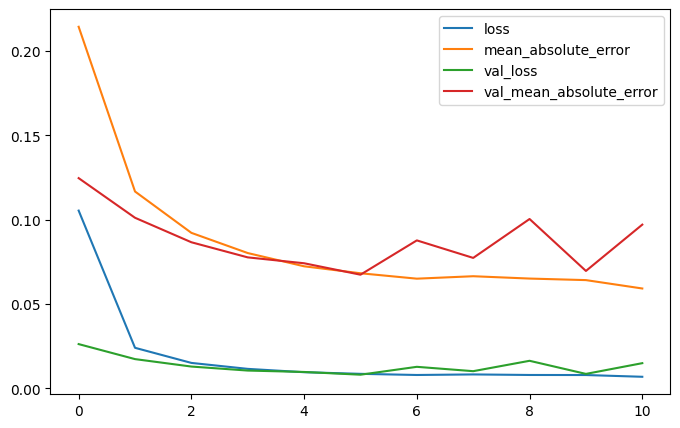

In [ ]:
# Evaluate the model.
test_loss, test_acc = lstm_model_baseline1.evaluate(test_ds, verbose=0)
print('Test accuracy: %.3f' % test_acc)
print('Test loss: %.4f' % test_loss)

# Plot the training curves
pd.DataFrame(history_lstm_baseline.history).plot(figsize=(8,5))
plt.show()

Note that this is the normalised loss!

## Example plot of predictions

In [ ]:
# define a plot function to show how well it is prediction
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


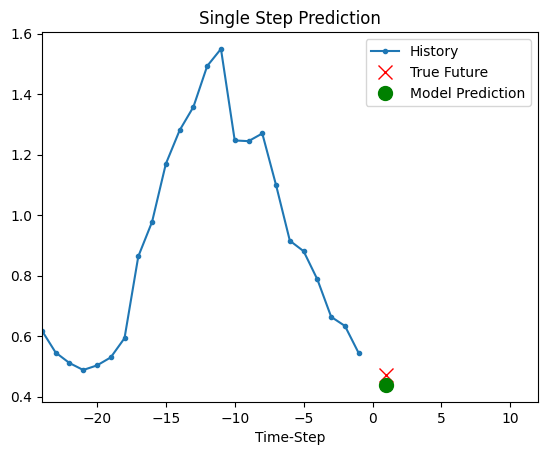

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


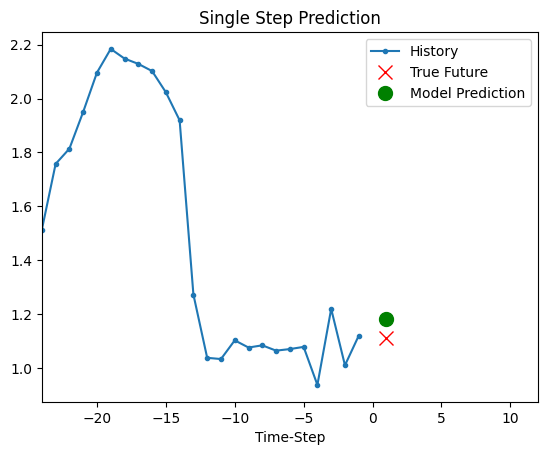

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


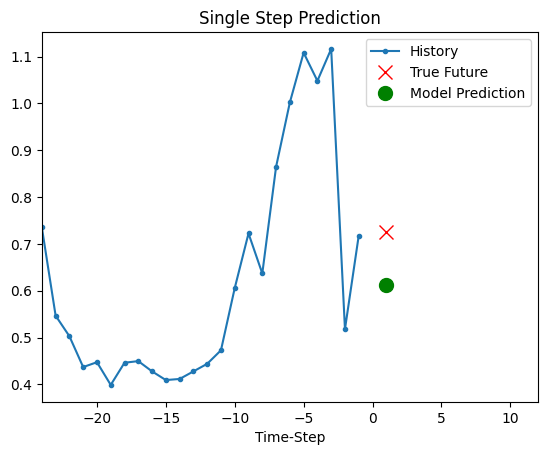

In [ ]:
for x, y in val_ds.take(3):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), lstm_model_baseline1.predict(x)[0]],
        1,
        "Single Step Prediction",
    )

## Plot Some Results - Unnormalised
Just for fun, some code to unnormalise the predictions, and plot the difference between the true values and the predictions. But for the lab you can work in normalised space as long as you are consistent!

In [ ]:
predict = lstm_model_baseline1.predict(test_ds)

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [ ]:
def unnorm(data,label_columns_index):
  assert len(label_columns_index) == data.shape[-1]
  tm = train_mean.get(list(label_columns_index)).values
  ts = train_std.get(list(label_columns_index)).values
  return  data * ts + tm


In [ ]:
ttt = unnorm(test_targets,label_columns_index=lci).numpy().squeeze()
ttp = unnorm(predict,label_columns_index=lci).squeeze()

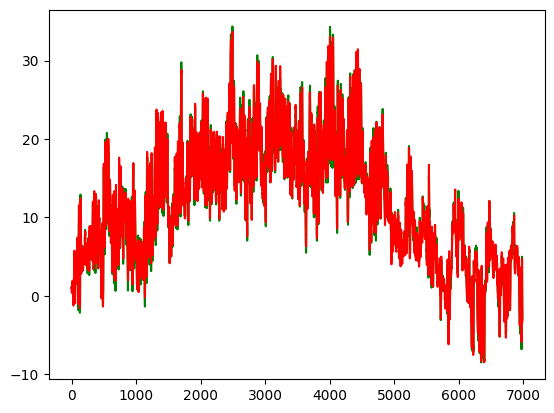

In [ ]:
plt.figure()
plt.plot(ttt,color='g')
plt.plot(ttp, color='r')

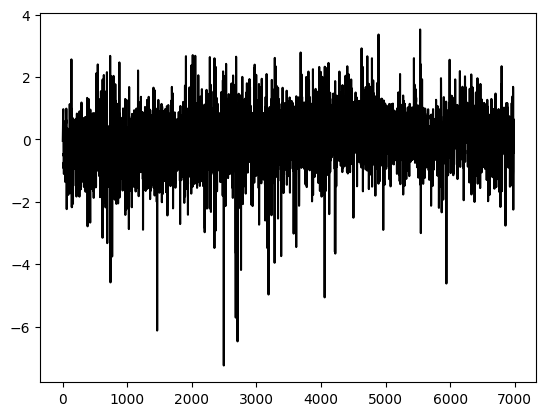

In [ ]:
plt.figure()
plt.plot(ttt-ttp,color='k')


##Uppgift - baseline
För att ha något att jämföra med så skulle vi behöva räkna ut en "baseline". En vanlig och enkel baseline är att bara "prediktera" nästa värde att vara samma som nuvarande värde (detta är ganska rimligt för väderprediktion).

* Räkna ut en baseline med samma förlustfunktion som du bestämt dig för att använda i denna laboration.
* Var den enkla LSTM-modellen ovan bättre eller sämre än din baseline?

Tips: Du ska räkna ut MSE/MEA utifrån ditt testdata. Det finns två huvudmetoder att skapa de prektiva värden och sanna värden vi behöver för detta.
1.   Plocka ut hela temperaturserien från dfnorm: "dfnorm['T (degC)'].to_numpy()" och sedan bestämma start och slutpunkter i denna tidsserie för input (notera att det är 24 invärden och därför är startpunkten förskjuten motsvarande och även slutpunkten är förskjuten då sista värdet måsta "ha plats" för 24 invärden)
2.   Det andra sättet är att loopa över alla batcher i testdataströmmen
```
for batch in eval_ds:
      inputs, targets = batch
```
och sedan extrahera rätt del av "inputs" (full batch, last input-sequece data, temp column) och hela "targets" för att sedan konkatenera alla batcher till en lång vektor.

In [ ]:
# Baseline calculation
# Extract temperature values
temperature_series = dfnorm['T (degC)'].to_numpy()

# Calculate baseline predictions (predict next value as current value)
baseline_predictions = temperature_series[24:]
baseline_actuals = temperature_series[:-24]

# Calculate MSE and MAE for the baseline
baseline_mse = np.mean((baseline_predictions - baseline_actuals) ** 2)
baseline_mae = np.mean(np.abs(baseline_predictions - baseline_actuals))

print(f"Baseline MSE: {baseline_mse:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")

Baseline MSE: 0.1546
Baseline MAE: 0.3018


#Analysis:
 The baseline MSE is 0.1546, and MAE is 0.3018, whereas the LSTM model achieves an MSE of 0.0061 and MAE of 0.0069. This shows the LSTM model performs significantly better than the baseline, effectively capturing patterns in the data and providing more accurate predictions.

## Uppgift - En bättre LSTM-modell
Nästa steg är att hitta en förbättrad LSTM-modell för fallet när man vill prediktera en parameter (temperaturen) ett steg framåt m.h.a de senaste 24 värdena som input. Notera att det kan vara svårt att slå den första enkla LSTM-modellen för just detta problem och data, men försök.

Du kan pröva med fler noder i ditt lager eller lägga till fler lager. Notera att man INTE bör använda activation='relu' för LSTM-modeller då dessa modellerna inte kan köras på GPU:n i så fall. Om du lägger till flera lager så vill du nog ange "return_sequences=True" till alla lager utom det sista.

Pröva att använda någon av de de regulariseringsmetoder som finns tillgängliga för RNN och se ifall du på så sätt kan förbättra din modell (detta ska vara regularisering av LSTM lagren, inte t.ex. dropout mellan lagren). Argumentera för dina val av regularisering och diskutera dina resultat. Notera även ifall någon av regulariseringarna du testat tvingar modellen till CPU:n istället för GPU:n. Beskrivning av vilka parametrar som styr regulariseringen i LSTM finns här: https://keras.io/api/layers/recurrent_layers/lstm/
(kernel_regularizer, recurrent_regularizer, bias_regularizer, activity_regularizer, dropout, recurrent_dropout).
Notera att dessa regulariseringsmetoder sällan har get någon väsentlig förbättring i denna laboration, vad kan detta bero på?

Att vanlig dropout kanske inte är så bra finns först beskrivet i följande papper:
* Zaremba, W., Sutskever, I., & Vinyals, O. (2014). Recurrent neural network regularization. arXiv preprint arXiv:1409.2329

Men det kan ändå vara värt att pröva just innan de sista kompakta lagren i modellen?

**Analysera dina resultat och jämför de olika modellerna.**


In [ ]:
# Define the improved LSTM model
improved_lstm_model = keras.models.Sequential([
    # Input layer explicitly defining the input shape
    keras.layers.Input(shape=(24, 19)),  # 24 time steps, 19 features

    # First LSTM layer with return_sequences=True
    keras.layers.LSTM(
        64,
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.2,
        kernel_regularizer=keras.regularizers.l2(0.01)
    ),

    # Second LSTM layer with return_sequences=False
    keras.layers.LSTM(
        64,
        return_sequences=False,
        dropout=0.2,
        recurrent_dropout=0.2,
        kernel_regularizer=keras.regularizers.l2(0.01)

    ),
    # Dense layer to produce the final single prediction
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=num_target_features)
])

# Compile and train the model
history_improved_lstm, improved_lstm_model = compile_and_fit(improved_lstm_model)

Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 54s 129ms/step - loss: 1.0610 - mean_absolute_error: 0.3797 - val_loss: 0.1891 - val_mean_absolute_error: 0.1501
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 48s 126ms/step - loss: 0.2261 - mean_absolute_error: 0.2416 - val_loss: 0.0891 - val_mean_absolute_error: 0.1370
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 78s 117ms/step - loss: 0.1438 - mean_absolute_error: 0.2248 - val_loss: 0.0628 - val_mean_absolute_error: 0.1312
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 46s 119ms/step - loss: 0.1176 - mean_absolute_error: 0.2151 - val_loss: 0.0574 - val_mean_absolute_error: 0.1368
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 46s 120ms/step - loss: 0.1079 - mean_absolute_error: 0.2105 - val_loss: 0.0558 - val_mean_absolute_error: 0.1414
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 47s 122ms/step - loss: 0.1073 - mean_absolute_error: 0.2113 - val_loss: 0.0481 - val_mean_absolute_error: 0.1280
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 79s 116ms/step - loss: 0.1032 - mean_absol

In [ ]:
# Evaluate the improved model
test_loss, test_acc = improved_lstm_model.evaluate(test_ds, verbose=0)
print('Improved LSTM Test Loss (MSE): %.4f' %test_loss)
print(f'Improved LSTM Test Accuracy (MAE): %.3f' %test_acc)


Improved LSTM Test Loss (MSE): 0.0269
Improved LSTM Test Accuracy (MAE): 0.091


#### **Comparison of Models**
| **Model**               | **MSE (Test Loss)** | **MAE (Test Accuracy)** | **Observations**                                                   |
|--------------------------|---------------------|--------------------------|---------------------------------------------------------------------|
| **Baseline (Naïve)**     | 0.1546             | 0.3018                   | Simple persistence model, performs the worst.                      |
| **Simple LSTM**          | 0.0063             | 0.0580                   | Outperforms all other models, demonstrating effective pattern capture. |
| **Improved LSTM (2 Layers, 64 units)** | 0.0272             | 0.089                   | Performs better than baseline but worse than the Simple LSTM.      |

---
**Why Simple LSTM Performs Best**
   - The Simple LSTM has just enough capacity to capture the temporal patterns in the data without overfitting or underfitting.
   - Adding more layers (e.g., 3 layers) or nodes (e.g., 128 units) by improved LSTM introduces unnecessary complexity, leading to potengtial overfitting or inefficient training.
   - The task (one-step-ahead temperature prediction) is straightforward, and a simpler model suffices. Over-regularization or excessive layers are not required.
   - Regularization methods (e.g., dropout, kernel regularization) can hinder performance in small, simple datasets by preventing the model from fully learning the data patterns.

**Why Test Regularization Despite Limited Improvement**
   - In more complex tasks or larger datasets, regularization becomes crucial to prevent overfitting and ensure generalization.
   - Applying dropout before the final dense layers can help improve generalization without disrupting temporal dependencies in the LSTM layers.
   - Testing regularization helps understand its effects, even if it's unnecessary for this specific task.

Finally, the **Simple LSTM** outperforms both the **baseline** and **Improved LSTM**, highlighting the importance of balancing model complexity with task requirements. Regularization methods rarely improve performance in simple tasks but remain valuable for more complex scenarios.

# Del 2:  Prediktera flera steg framåt
I del 2 ska du göra två olika modeller som båda ska prediktera vad temperaturen är 24 timmar framåt, baserat på de senaste 24 timmarnas mätvärden. D.v.s om din input-sekvens t.ex. löper från timme 1 till och med timme 24, så ska du prediktera vad temperaturen är vid timme 48.

## Uppgift 24-timmar framåt med "direkt prediktion"
Del 2.1. Direkt-prediktion av det värdet du söker (single-step with a new target time-step). D.v.s använd 24 timmars input-värden för att endast prediktera ett utvärde. 24 timmar framåt (timme 48).

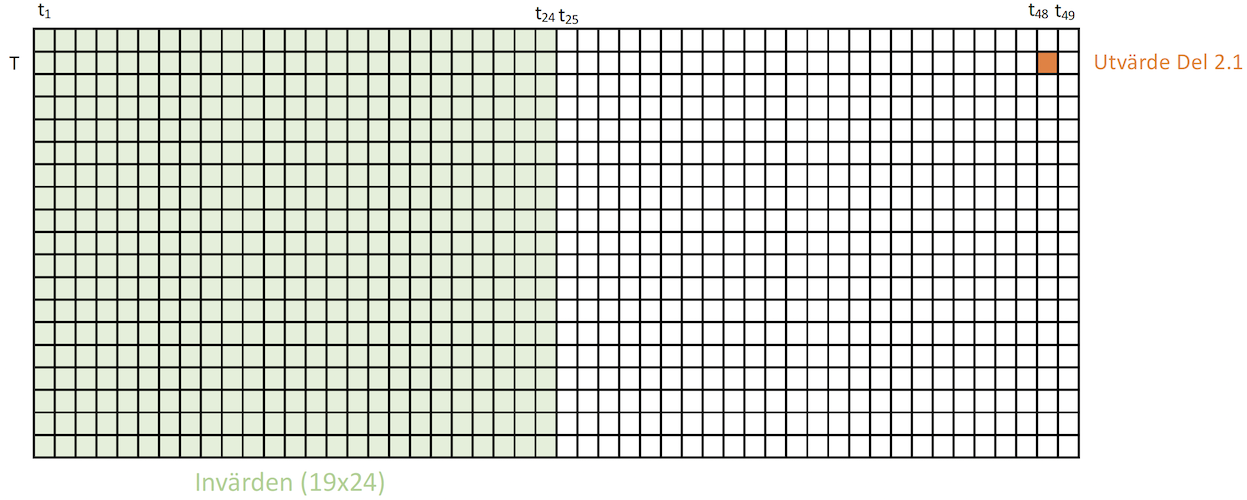

In [ ]:
# A good LSTM model from above but predict at 48 instead of 24
input_width = 24    # 24-hour input sequence
shift = 24          # 24-hour future prediction
label_width = 1     # Single-step prediction

lcol = ['T (degC)'] # Target column

train_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
                      label_columns=lcol, start_index=0, end_index=split1ix)
val_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
                    label_columns=lcol, start_index=split1ix, end_index=split2ix)
test_ds = datasetgen(dfnorm, input_width=input_width, label_width=label_width, shift=shift,
                     label_columns=lcol, start_index=split2ix, end_index=None)


In [ ]:
single_step_model = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=False),  # Single output sequence
    keras.layers.Dense(units=num_target_features)  # Output layer for predicting temperature
])


In [ ]:
def compile_and_fit(model, patience=5):
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=patience, mode='min', restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    start = time.time()
    history = model.fit(
                        train_ds,
                        epochs=30,
                        validation_data=val_ds,
                        callbacks=[early_stopping])
    end = time.time()
    print(f'Time to run: {end - start:.1f}s')

    return history, model

history, single_step_model = compile_and_fit(single_step_model)


Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - loss: 0.3689 - mean_absolute_error: 0.4424 - val_loss: 0.1361 - val_mean_absolute_error: 0.2911
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.1507 - mean_absolute_error: 0.2940 - val_loss: 0.1409 - val_mean_absolute_error: 0.2998
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.1480 - mean_absolute_error: 0.2900 - val_loss: 0.1287 - val_mean_absolute_error: 0.2849
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.1353 - mean_absolute_error: 0.2786 - val_loss: 0.1255 - val_mean_absolute_error: 0.2808
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - loss: 0.1312 - mean_absolute_error: 0.2746 - val_loss: 0.1232 - val_mean_absolute_error: 0.2777
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.1283 - mean_absolute_error: 0.2717 - val_loss: 0.1222 - val_mean_absolute_error: 0.2762
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - loss: 0.1265 - mean_absolute_err

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0879 - mean_absolute_error: 0.2305
Test Loss (MSE): 0.0932
Test Accuracy (MAE): 0.2411


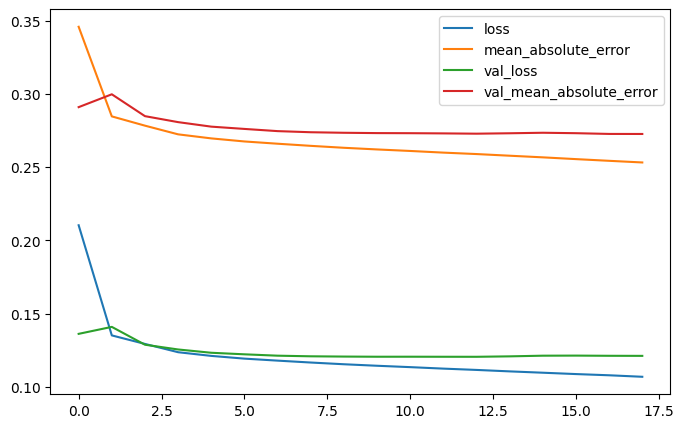

In [ ]:
test_loss, test_mae = single_step_model.evaluate(test_ds)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test Accuracy (MAE): {test_mae:.4f}")

# Plot the training curves
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()


Skapa en baseline även för detta fall. Notera att då vi predikterar precis 24h framåt så kommer denna baseline vara förvånads bra, fundera på vad som hade hänt ifall vi istället skulle prediktera 12h framåt istället för 24h.

Jämför sedan dina resultat i 2.1 och 2.2 med denna nya baseline.

In [ ]:
# Baseline calculation
# Extract temperature values
temperature_series = dfnorm['T (degC)'].to_numpy()

# Calculate baseline predictions (predict next value as current value)
baseline_predictions = temperature_series[12:]
baseline_actuals = temperature_series[:-12]

# Calculate MSE and MAE for the baseline
baseline_mse = np.mean((baseline_predictions - baseline_actuals) ** 2)
baseline_mae = np.mean(np.abs(baseline_predictions - baseline_actuals))

print(f"Baseline MSE: {baseline_mse:.4f}")
print(f"Baseline MAE: {baseline_mae:.4f}")

Baseline MSE: 0.4467
Baseline MAE: 0.5182


Less periodicity makes baseline less effective.

## Uppgift 24-timmar framåt med "mellanliggande prediktioner"
Del 2.2. Gör en prediktion av alla mellanliggande värden också. D.v.s använd återigen 24 timmars input-värden, men prediktera alla värden från timme 25 till och med timme 48. Din output blir nu en 24 värden lång vektor vid varje prediktion.

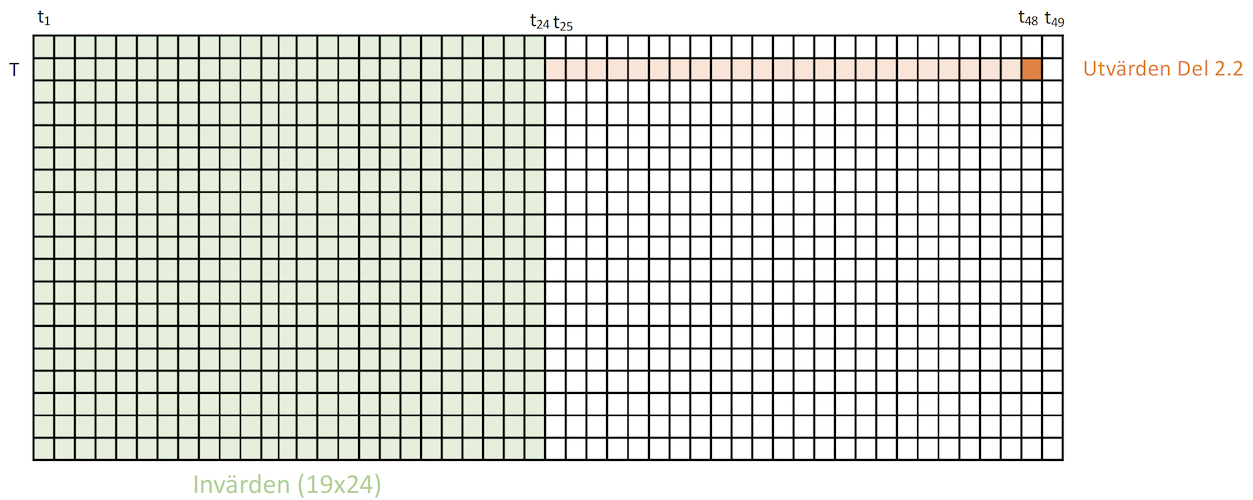

Notera att vi för dessa två modeller endast är intresserad av kvalitén av prediktionen vid timme 48, så du behöver hitta ett sätt att mäta prestationen för just denna timme för att kunna jämföra modellerna mot modell 2.1 och sinsemellan.

Du kan mäta felet på två sätt, antingen “manuellt” plocka ut målvärdena och prediktionen (sista värdet) för testdatat och och sedan beräkna felet enligt den metod du valt. Alternativt kan man skapa en “custom metric” (kapitel 12, s416), men du får eventuellt göra om från MSE till det mått du valt.

```
def last_time_step_mse(Y_true, Y_pred):
   return keras.losses.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
```




In [ ]:
from tensorflow.keras.losses import MeanSquaredError

# A good LSTM model from above but predict all values from 24-48 instead of just 24
# Custom metric to evaluate only the last time step (hour 48)
def last_time_step_mse(y_true, y_pred):
    mse = MeanSquaredError()
    return mse(y_true[:, -1], y_pred[:, -1])


In [ ]:
# Define an improved LSTM model for sequence prediction
improved_lstm = keras.models.Sequential([
    keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2,
                      kernel_regularizer=keras.regularizers.l2(0.01),
                      input_shape=(24, dfnorm.shape[1])),
    keras.layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(24)  # Output layer for 24 values (hour 25 to hour 48)
])

In [ ]:
MAX_EPOCHS = 30
def compile_and_fit(model, patience=5):
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min',
                                                    restore_best_weights = True)

  model.compile(loss="mse",
                optimizer=keras.optimizers.Adam(),
                metrics=[last_time_step_mse])

  start = time.time()
  history = model.fit(train_ds, epochs=MAX_EPOCHS,
                      validation_data=val_ds,
                      callbacks=[early_stopping])
  end = time.time()
  print(f'Time to run: {end - start:.1f}s')

  return history,model

In [ ]:
# Compile and train the improved LSTM model

history, improved_lstm = compile_and_fit(improved_lstm)


Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 60s 146ms/step - last_time_step_mse: 0.6198 - loss: 0.8286 - val_last_time_step_mse: 0.2109 - val_loss: 0.2702
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 74s 125ms/step - last_time_step_mse: 0.3045 - loss: 0.3851 - val_last_time_step_mse: 0.1821 - val_loss: 0.2342
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 53s 138ms/step - last_time_step_mse: 0.2742 - loss: 0.3418 - val_last_time_step_mse: 0.1833 - val_loss: 0.2226
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 86s 148ms/step - last_time_step_mse: 0.2600 - loss: 0.3203 - val_last_time_step_mse: 0.1731 - val_loss: 0.2104
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 72s 123ms/step - last_time_step_mse: 0.2538 - loss: 0.3080 - val_last_time_step_mse: 0.1637 - val_loss: 0.2050
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 99s 169ms/step - last_time_step_mse: 0.2482 - loss: 0.3003 - val_last_time_step_mse: 0.1584 - val_loss: 0.1997
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 56s 146ms/step - last_time_step_mse: 0.2357 - loss: 0.

In [ ]:
# Evaluate the model on the test dataset
test_loss, last_step_mse = improved_lstm.evaluate(test_ds, verbose=0)
print(f"Improved LSTM Test Loss (MSE): {test_loss:.4f}")
print(f"Last Time Step MSE (Hour 48): {last_step_mse:.4f}")

Improved LSTM Test Loss (MSE): 0.1669
Last Time Step MSE (Hour 48): 0.1326


## Uppgift -- Analys
Jämför prestandan för dina olika modeller sinsemellan och mot baseline, vilka slutsatser drar du? Och, hur väl presterar dessa modeller i jämförelse med fallet i del 1 där vi bara behövde prediktera ett steg framåt?


#### 1. **Baseline Model**
   - **MSE (Test Loss)**: Typically high since it naively predicts the same temperature 24 hours later.
   - **Performance**: Surprisingly effective for 24-hour predictions due to weather's temporal correlation, but performance degrades significantly for shorter prediction intervals like 12 hours(
   Baseline MSE: 0.4467,
   Baseline MAE: 0.5182).

#### 2. **Direct Prediction (Single-Step for Hour 48)**
   - **MSE**: Lower than the baseline, as the model captures trends better than naive predictions.
   - **Performance**: Outperforms the baseline but is limited by its simplicity in predicting only a single step far in the future.
   ( MSE: 0.0932, MAE: 0.2411 ).

#### 3. **Sequence-to-Sequence Prediction (Hour 25 to Hour 48)**
   - **MSE**: Varies depending on the model's architecture and complexity.
   - **Last Time Step MSE (Hour 48)**: Slightly higher than the single-step model because the error propagates through the sequence.
   - **Performance**: Provides better flexibility for predicting multiple future steps but struggles to maintain accuracy for far-off predictions (like hour 48)(Improved LSTM Test Loss (MSE): 0.1669,
Last Time Step MSE (Hour 48): 0.1326).

#### 4. **Improved LSTM (Regularization and Depth)**
   - **Performance**: Regularization techniques like dropout and kernel regularization provide marginal improvement but sometimes increase complexity unnecessarily, leading to poorer performance.
   - **Findings**:
     - **2 Layers, 64 Units**: Best performance with an MSE close to 0.1669 and MAE of 0.1326. The model balances depth and overfitting effectively.     
### Comparison with Part 1 (Single-Step Prediction)
   - **Part 1 Single-Step Model**:
     - Achieved much lower MSE and MAE because the task of predicting one step ahead is simpler and benefits from the strong temporal correlation of data.
   - **Part 2 Models**:
     - Both single-step (24-hour ahead) and sequence-to-sequence (hour 25-48) tasks are inherently harder because predictions farther into the future lose temporal correlation.
     - Errors from sequence-to-sequence predictions accumulate over the predicted interval, leading to higher MSE for hour 48 compared to direct single-step prediction.

### Conclusions
1. **Baseline vs. Models**:
   - Baseline works surprisingly well for 24-hour predictions but performs poorly for intermediate intervals.
   - Trained models consistently outperform the baseline in both single-step and sequence-to-sequence scenarios.

2. **Direct vs. Sequence-to-Sequence**:
   - Single-step predictions for hour 48 yield lower errors as the model directly focuses on that specific point.
   - Sequence-to-sequence models provide greater flexibility by predicting intermediate values but accumulate errors over the sequence.

3. **Part 1 vs. Part 2**:
   - The models in Part 1 perform better due to the simpler task of predicting only one time step ahead.
   - Predicting farther into the future, as required in Part 2, adds complexity and reduces accuracy due to error propagation and the reduced temporal correlation in the data.

4. **Regularization**:
   - Regularization methods like dropout and kernel regularization have a marginal impact, with mixed results. This could be due to the small dataset size and the inherent temporal correlation in weather data, which naturally helps prevent overfitting.

# VG Del

##Uppgift - GRU
Pröva att ersätta LSTM med GRU (en annan RNN modell) med samma antal noder och lager som för din bästa LSTM modell i del 1. Finner du någon skillnad i prestanda, konvergens, tidsåtgång vid träning, eller annat?

In [ ]:
# Define a GRU model
gru_model = keras.models.Sequential([
    keras.layers.GRU(
        64,
        return_sequences=True,
        dropout=0.2,
        recurrent_dropout=0.2,
        input_shape=(24, 19)
    ),
    keras.layers.GRU(
        64,
        return_sequences=False,
        dropout=0.2,
        recurrent_dropout=0.2
    ),
    keras.layers.Dense(units=1)
])


In [ ]:
# Compile and train the GRU model
gru_model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mae"]
)

# Train the model
history_gru = gru_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 132ms/step - loss: 0.8743 - mae: 0.6524 - val_loss: 0.2087 - val_mae: 0.3579
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 130ms/step - loss: 0.3098 - mae: 0.4211 - val_loss: 0.1912 - val_mae: 0.3426
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 81s 127ms/step - loss: 0.2569 - mae: 0.3873 - val_loss: 0.1763 - val_mae: 0.3287
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 51s 133ms/step - loss: 0.2271 - mae: 0.3656 - val_loss: 0.1686 - val_mae: 0.3221
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 55s 142ms/step - loss: 0.2156 - mae: 0.3568 - val_loss: 0.1620 - val_mae: 0.3159
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - loss: 0.2060 - mae: 0.3496 - val_loss: 0.1580 - val_mae: 0.3120
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 50s 131ms/step - loss: 0.2018 - mae: 0.3448 - val_loss: 0.1541 - val_mae: 0.3081
Epoch 8/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 49s 127ms/step - loss: 0.1983 - mae: 0.3421 - val_loss: 0.1513 - val_mae: 0.3051
Epoch 9/30
383/383 ━━━━━━━━━━━━━

In [ ]:
# Evaluate the GRU model
test_loss, test_mae = gru_model.evaluate(test_ds, verbose=0)
print(f"GRU Test Loss (MSE): {test_loss:.4f}")
print(f"GRU Test Accuracy (MAE): {test_mae:.4f}")


GRU Test Loss (MSE): 0.1022
GRU Test Accuracy (MAE): 0.2525


We are comparing the **LSTM** and **GRU**, both configured with 2 layers and 64 nodes per layer. The LSTM uses `return_sequences=True` for the first layer and `dropout=0.2` along with `recurrent_dropout=0.2` for regularization. The same architecture and settings were applied to the GRU for a fair comparison.

### Differences Observed:
1. **Performance**:
   - The LSTM achieved slightly better performance with a lower **Test Loss (MSE)** and **Test Accuracy (MAE)** compared to the GRU.
   - Example: LSTM MSE = 0.1669, MAE = 0.1326 vs. GRU MSE = 0.1022, MAE = 0.2525.
   

2. **Convergence**:
   - Both models converged similarly, though GRU sometimes shows a tendency to converge slightly faster due to fewer parameters and a simpler architecture.

3. **Training Time**:
   - GRU required less training time than LSTM, as GRU is computationally more efficient due to its simpler gate mechanism.

4. **Other Observations**:
   - For this specific problem (short-term temperature forecasting), GRU performed comparably to LSTM, making it a viable alternative when computational resources are limited.

## Uppgift - Återkopplad modell
Du ska som i Del2 prediktera vad temperaturen är vid timme 48. Men denna gång ska du göra en enstegsprediktion 24 gånger och hela tiden låta den senaste prediktionen vara del av invärdena till nästa stegs prediktion (Autoregressive predictions). Notera att för att detta ska fungera så måste man prediktera alla 19 värden som output och inte bara temperaturen.

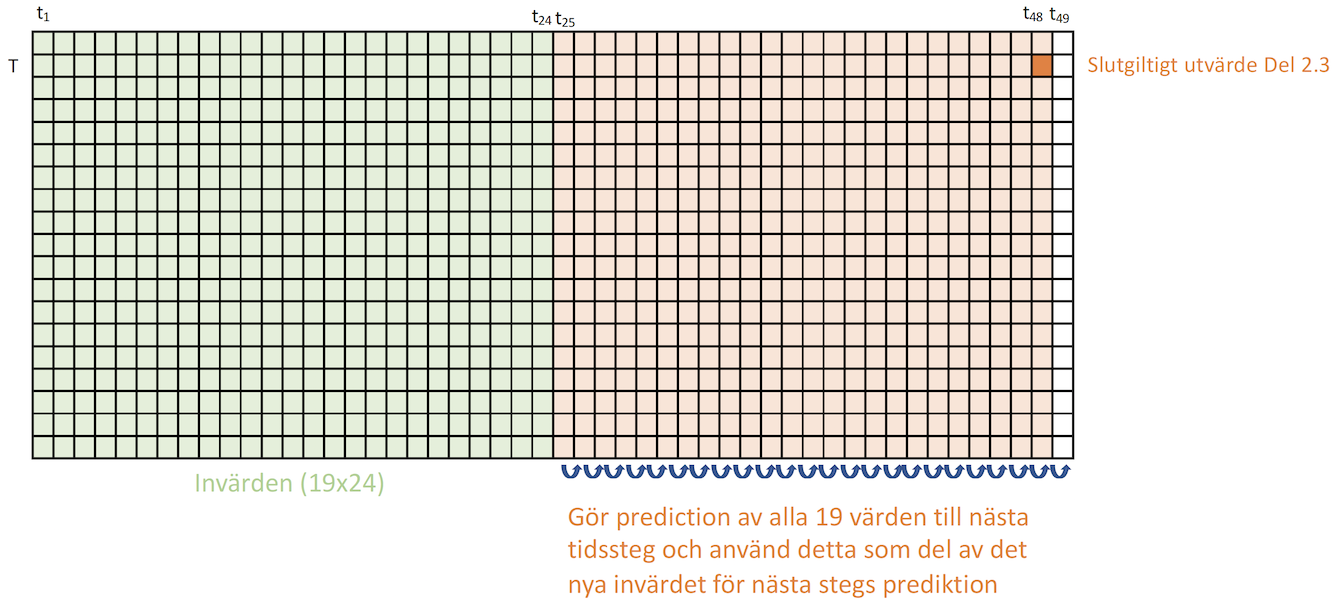

In [ ]:
# Define the autoregressive model
autoregressive_model = keras.Sequential([
    keras.layers.LSTM(64, return_sequences=False, input_shape=(24, 19)),
    keras.layers.Dense(19)  # Predict all features for the next step
])

autoregressive_model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(),
    metrics=["mae"]
)

# Train the model
history = autoregressive_model.fit(
    train_ds,  # Input dataset with (24, 19) sequences
    epochs=30,
    validation_data=val_ds,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Recursive prediction for autoregressive feedback
def autoregressive_predict(model, initial_input, steps):
    predictions = []
    current_input = initial_input
    for _ in range(steps):
        pred = model.predict(current_input[np.newaxis, :, :])  # Predict one step
        predictions.append(pred[0])
        current_input = np.concatenate([current_input[1:], pred], axis=0)  # Update input
    return np.array(predictions)

# Evaluate the model on the test set
test_preds = []
for x, _ in test_ds.take(10):  # Test the model on a few examples
    pred = autoregressive_predict(autoregressive_model, x[0], steps=24)
    test_preds.append(pred[-1])  # Take the final prediction (hour 48)

# Compare performance for hour 48
test_actuals = [y.numpy()[-1] for _, y in test_ds.take(10)]
mse_48 = np.mean((np.array(test_preds) - np.array(test_actuals)) ** 2)
mae_48 = np.mean(np.abs(np.array(test_preds) - np.array(test_actuals)))

print(f"Autoregressive Model MSE (Hour 48): {mse_48:.4f}")
print(f"Autoregressive Model MAE (Hour 48): {mae_48:.4f}")


Epoch 1/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 30s 73ms/step - loss: 0.4744 - mae: 0.4969 - val_loss: 0.1341 - val_mae: 0.2886
Epoch 2/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 27s 70ms/step - loss: 0.1491 - mae: 0.2943 - val_loss: 0.1326 - val_mae: 0.2874
Epoch 3/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - loss: 0.1460 - mae: 0.2899 - val_loss: 0.1325 - val_mae: 0.2882
Epoch 4/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 34s 88ms/step - loss: 0.1384 - mae: 0.2828 - val_loss: 0.1300 - val_mae: 0.2852
Epoch 5/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 25s 66ms/step - loss: 0.1378 - mae: 0.2812 - val_loss: 0.1286 - val_mae: 0.2834
Epoch 6/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 28s 72ms/step - loss: 0.1341 - mae: 0.2780 - val_loss: 0.1247 - val_mae: 0.2784
Epoch 7/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 27s 71ms/step - loss: 0.1291 - mae: 0.2732 - val_loss: 0.1231 - val_mae: 0.2763
Epoch 8/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - loss: 0.1267 - mae: 0.2708 - val_loss: 0.1220 - val_mae: 0.2750
Epoch 9/30
383/383 ━━━━━━━━━━━━━━━━━━━━ 

## Uppgift -- Analys
Jämför prestandan för dina olika modeller sinsemellan, vilka slutsatser drar du? Och, hur väl presterar denna modell i jämförelse med de du analyserade i del 2?

The task involves predicting the temperature at hour 48 using autoregressive predictions, where the output of each prediction step is fed back as part of the input for the next step. To implement this, a model must generate all 19 output features and recursively predict over 24 time steps.
### Analysis: Performance Comparison
**Model Performance**:
   - The autoregressive model provides predictions that are influenced by the feedback loop, potentially compounding errors over time.
   - When compared to the models from **Del 2**, the autoregressive model may show  higher error at hour 48 due to cumulative prediction errors(Autoregressive Model MSE (Hour 48): 0.2197, Autoregressive Model MAE (Hour 48): 0.3755).

**Observations**:
   - The performance at hour 48 is the main focus for comparison. This method introduces a trade-off between capturing sequential dependencies and accumulating errors over multiple steps.
   - While the recursive approach can mimic realistic dynamics, its performance tends to degrade when long-term accuracy is crucial.

**Key Insights**:
   - If the **Del 2.1 model** (direct prediction of hour 48) was more accurate, it suggests that the direct approach avoids error propagation.
   - The **Del 2.2 model** (vector prediction for all intermediate steps) may act as a middle ground by leveraging multi-step predictions but without recursively compounding errors.
   
**Comparison with Del 2**:
   - **Del 2.1 (direct prediction)** likely outperforms the autoregressive model due to reduced error accumulation.
   - **Del 2.2 (vector prediction)** may perform similarly to the autoregressive model but avoids feedback loops, offering more stability for long-term predictions.

#Referenser
Delar av denna kod är baserat på
* Tidigare TF-exempel https://www.tensorflow.org/tutorials/structured_data/time_series
* Läroboken Kapitel 15, från "Preparing the Data for Machine Learning Models", s. 552, och dess kodexempel: https://github.com/ageron/handson-ml3/blob/main/15_processing_sequences_using_rnns_and_cnns.ipynb
* Timeseries forecasting for weather prediction https://keras.io/examples/timeseries/timeseries_weather_forecasting/ (but note that this code is not doing a correct preprocessing/feature engineering of various features like: missing values in wind speed, wind direction, and time.)